# Calculating the productivity for animals under the ontogenetic model


On an earlier [post](https://thefuturewithoutanimalproducts.com/2018/05/01/animals-by-the-numbers-2-productivity/), I calculated the maximum growth rate for animals using the ontogenetic models. However, to be consistent with the [calculation for the yield](../yield/notebook.ipynb) used in the book, it'd be good to do the weighted average growth rate instead.

First start with the typical growth equation for microbes, whose maintenance requirements are generally assumed to be so small that a simple exponential equation does the trick:

$$\frac{dm}{dt}=\mu m$$

When discussing growth rates of microbes, we typically refer to this $\mu$ value. If we were to derive as the average growth rate (which is trivial because it's constant), we could could normalize the equation above (divide by $m$) and take the weighted average of that over the development, which simply evaluates to $\mu$.

Let's take this approach to the animal ontogenetic model. Start with the equation for the change in mass over time from West et al. 2001:

$$\frac{dm}{dt}=a m^{3/4} \left[ 1 - \left(\frac{m}{M}\right)^{1/4} \right]$$

Divide (normalized) by $m$:

$$\frac{d\overline{m}}{dt}=a \left[ \left(\frac{1}{m}\right)^{1/4} - \left(\frac{1}{M}\right)^{1/4} \right]$$

Substitute our equation for m over time (can used normalized time $\tau$):

$$m(\tau) = M \left( 1 - e^{-\tau} \right)^4 $$

$$\frac{d\overline{m}}{dt}=\frac{a}{M^{1/4}} \left[ \left(\frac{1}{ 1 - e^{-\tau} }\right) - 1 \right]$$

Now we must take the weighted average over the development of the animal as we did for the [yield](../yield/notebook.ipynb).

$$ \overline{\mu}(\tau) = \frac{\int_{0}^{\tau} M \left( 1 - e^{-\tau} \right)^4 \frac{d\overline{m}}{dt} d\tau}{\int_{0}^{\tau} M \left( 1 - e^{-\tau} \right)^4 d\tau} $$


$$ \overline{\mu}(\tau) = \frac{a}{M^{1/4}} \frac{\int_{0}^{\tau}  \left[  \left( 1 - e^{-\tau} \right)^3 -  \left( 1 - e^{-\tau} \right)^4 \right] d\tau}{\int_{0}^{\tau}  \left( 1 - e^{-\tau} \right)^4 d\tau} $$

We can plug in $\tau=3$ and evaluate to obtain our average growth rate for an animal from birth until maturity (slaughter) weight:

$$ \overline{\mu}(3) \approx (0.18 \text{ per day}) \frac{a}{M^{1/4}} $$

In [10]:
import scipy.integrate as integrate
import numpy as np

#define our maturity time
maturityTime=3

#beause of the annoying way that integrate.quad works, we need to split the integrations
resultNumerator = integrate.quad(lambda t: np.power((1-np.exp(-t)),3) - np.power((1-np.exp(-t)),4), 0, maturityTime)[0]
resultDenominator = integrate.quad(lambda t: np.power((1-np.exp(-t)),4), 0, maturityTime)[0]
constant=resultNumerator/resultDenominator

#calculate our final result
print(constant)

#divide by 24, converting to per hour
print(constant/24)

0.18385342405840296
0.00766055933576679


The above equation has units of per day. In order to compare to microorganisms, we convert to per hour, so we divide by 24:

$$ \overline{\mu} \approx (0.0077 \text{ per hour}) \frac{a}{M^{1/4}} $$

Now we calculate for various animals:

In [8]:
def findAverageGrowthRate( a, M):
    gr = 0.0077 *a /np.power(M,1/4)
    return gr

animals = { "cow": 
               {
                   "a": 0.276,
                    "M": 442000,
                    "m0": 33333
                   },
           "hen":
               {
                   "a": 0.47,
                   "m0": 43,
                   "M": 2100
               },
           "salmon":
               {
                   "a": 0.026,
                   "m0": 0.01,
                   "M": 2400
               },
           "shrimp":
               {
                   "a": 0.027,
                   "m0": 0.0008,
                   "M": 0.075
               }
}

for animal in animals.keys():
    print(animal + ": " + str(findAverageGrowthRate(animals[animal]["a"] ,animals[animal]["M"] )) + " per hour")

cow: 8.24222071053747e-05 per hour
hen: 0.0005346059148102572 per hour
salmon: 2.860297870128498e-05 per hour
shrimp: 0.00039727311299857574 per hour


I also tabulated growth rates from various kingdoms (e.g bacteria). Summary information is shown:

In [9]:
import pandas as pd
from IPython.display import display, HTML

xl = pd.ExcelFile("../../animalnumbers2/growthrates.xlsx")
df = xl.parse("Sheet1",index_col=0)
display(df)

,Organism,Growth Rate (1/h),Reference
Short Name,,,
bacteria,Fast growing bacteria (e.g. E. coli),1.000000,http://bionumbers.hms.harvard.edu/bionumber.as...
yeast,Yeast,0.300000,http://bionumbers.hms.harvard.edu/bionumber.as...
in vitro meat,Mammalian cells in vitro,0.030000,http://bionumbers.hms.harvard.edu/bionumber.as...
leafy,"Plants (Arabidopsis - cabbage, mustard)",0.008333,http://bionumbers.hms.harvard.edu/bionumber.as...
chestnut,Chestnut tree,0.000029,http://www.chestnuthilloutdoors.com/store/pg/9...
almond,Almond tree,0.000019,http://homeguides.sfgate.com/almond-tree-growt...


Finally, we generate a figure to illustrate the differences in growth rate. We plot the y scale log because otherwise, our values would be too squished.

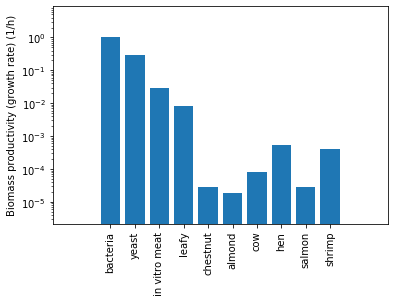

In [26]:
import matplotlib.pyplot as plt

all_gr = {}
for index, row in df.iterrows():
    all_gr[index] = {
        'growthrate': row['Growth Rate (1/h)'],
        'description': row['Organism']
    }

for animal in animals.keys():
    all_gr[animal] = {
        'growthrate': findMaxGR(animals[animal]["a"] ,animals[animal]["M"] ),
        'description': 'Animal flesh'
    }


y = []
labels = []

for item in all_gr.keys():
    labels.append(item)
    y.append(all_gr[item]['growthrate'])

fig, ax = plt.subplots()
plt.bar(np.arange(len(y)), y)

ax.set_yscale('log')
plt.xticks(np.arange(len(y)), labels, rotation='vertical')

plt.margins(0.2)
plt.ylabel('Biomass productivity (growth rate) (1/h)')
#plt.show()
plt.savefig('growthrates.svg')